In [1]:
import sys
sys.path.append(r'C:\Users\maxfu\OneDrive\Documentos\Master\Maximaster\Year 2 - Period 1\Project\Double Pendulum\Double Pendulum')
import numpy as np
from scinet import *
import scinet.pendulum as edo
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.feature_selection import mutual_info_regression
from scipy.integrate import odeint

Instructions for updating:
non-resource variables are not supported in the long term


# Data loading and testing #

Once the program has been trained, we can check the output results.

In [2]:
saved = nn2.Network.from_saved('Double Pendulum data')

{'latent_size': 4, 'input_size': 1000, 'input2_size': 1, 'output_size': 1, 'encoder_num_units': [500, 100], 'decoder_num_units': [100, 100], 'tot_epochs': 6000, 'name': 'Unnamed', 'load_file': 'Double Pendulum V6 4N'}
INFO:tensorflow:Restoring parameters from C:\Users\maxfu\OneDrive\Documentos\Master\Maximaster\Year 2 - Period 1\Project\Double pendulum\Double Pendulum\tf_save/Double Pendulum V6 4N.ckpt
Loaded network from file Double Pendulum V6 4N


We define the data generation functions for the predictions. 

In [4]:
def derivatives(sol,t,L1,L2,m1,m2):
    
    g=9.81
    Theta_1,Theta_1_dot,Theta_2,Theta_2_dot = sol
    
    C1=np.cos(Theta_1-Theta_2)
    C2=np.sin(Theta_1-Theta_2)
    
    # The first derivative of Theta is named Z, and so the second derivative is named Z_dot
    
    Z_1=Theta_1_dot
    Z_2=Theta_2_dot
    Z_1_dot=(m2*g*np.sin(Theta_2)*C1-m2*C2*(L1*Z_1**2*C1+L2*Z_2**2)-(m1+m2)*g*np.sin(Theta_1))/(L1*(m1+m2*C2**2))
    Z_2_dot=((m1+m2)*(L1*Z_1**2*C2-g*np.sin(Theta_2)+g*np.sin(Theta_1)*C1)+m2*L2*Z_2**2*C2*C1)/(L2*(m1+m2*C2**2))
    
    return Z_1,Z_1_dot,Z_2,Z_2_dot

################################################################################################

# This input generation is part of the first model. It is here in case we need to go back to it
# but is currently unused.

def gen_input(Theta_1_ini,Theta_2_ini,L1,L2,m1,m2, t_predicted):
    
    t_in = np.linspace(0, 5, 1000)
    sol_i = np.array([Theta_1_ini,0,Theta_2_ini,0])
    sol = np.array([odeint(derivatives, sol_i, t_in, args=(L1,L2,m1,m2)) for _ in t_predicted])
    Theta_1,Theta_2=sol[:,:,0],sol[:,:,2]
    time = np.reshape(t_predicted, (-1, 1))
    out1 = time #dummy filler
    out2 = time #dummy filler
    return [Theta_1,Theta_2, time, out1, out2]

################################################################################################

def gen_input_2(Theta_1_ini,Theta_2_ini,L1,L2,m1,m2, t_predicted):
    
    t_in = np.linspace(0, 5, 1000)
    sol_i = np.array([Theta_1_ini,0,Theta_2_ini,0])
    sol = np.array([odeint(derivatives, sol_i, t_in, args=(L1,L2,m1,m2)) for _ in t_predicted])
    Theta_1,Theta_2=sol[:,:,0],sol[:,:,2]
    time = np.reshape(t_predicted, (-1, 1))
    out = time #dummy filler
    return [Theta_2, time, out]

################################################################################################

In [5]:
blue_color='#033cff'
orange_color='#ff7700'

In [6]:
def pendulum_prediction(net, Theta_1_i, Theta_2_i, L1, L2, m1, m2):    
    
    t_given = np.linspace(0, 10, 250)
    t_predicted = np.linspace(0, 10, 250)
    
    ################################################
    
    sol_i_given = np.array([Theta_1_i,0,Theta_2_i,0])
    sol_given = odeint(derivatives, sol_i_given, t_given, args=(L1,L2,m1,m2))
    Theta_1_given,Theta_2_given=sol_given[:,0],sol_given[:,2]
    
    ################################################
    
    Theta_2_pred = net.run(gen_input_2(Theta_1_i,Theta_2_i,L1,L2,m1,m2, t_predicted), net.output).ravel()
    print(Theta_2_pred.shape)
    ################################################    
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.plot(t_given, Theta_2_given, color='darkorange', label='Given')
    ax.plot(t_predicted, Theta_2_pred,'--', color='purple', label='Predicted')
    ax.set_xlabel('$time$ [$s$]')
    ax.set_ylabel('$x_{2}$ [$m$]')
    plt.suptitle('Double Pendulum Prediction')
    plt.title('Parameters: L1={0}, L2={1}, m1={2}, m2={3}'.format("%.2f" % L1, "%.2f" % L2, "%.2f" % m1, "%.2f" % m2))
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    lgd=ax.legend(handles, labels,loc='upper right', shadow=True, ncol=1)
    fig.tight_layout()
    return fig

In [9]:
# We can randomly select the initial parameters. This range is controlled so that  

L1=np.random.uniform(1,1.15)
L2=np.random.uniform(1,1.15)
m1=np.random.uniform(1,1.15)
m2=np.random.uniform(1,1.15)

(250,)


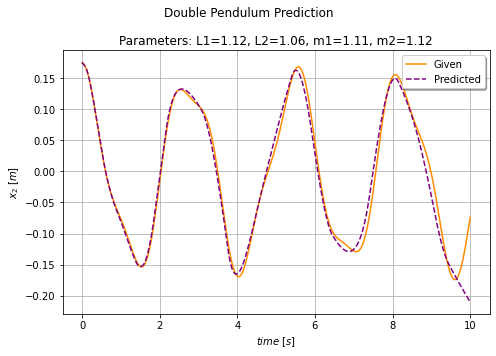

In [10]:
pendulum_prediction(saved, np.pi/36, np.pi/18, L1, L2, m1, m2);

In [10]:
def double_pendulum_representation_plot(net, L1_range, L2_range, m1_range, m2_range, step_num=100, eval_time=7.5):

    L_1 = np.linspace(*L1_range, num=step_num)
    L_2 = np.linspace(*L2_range, num=step_num)
    m_1 = np.linspace(*m1_range, num=step_num)
    m_2 = np.linspace(*m2_range, num=step_num)

    L1_grid, L2_grid, m1_grid, m2_grid = np.meshgrid(L_1,L_2,m_1,m_2)

    out = np.array([net.run(gen_input(0, np.pi/8,L1,L2,m1,m2,[eval_time]), net.mu)[0] for L1,L2,m1,m2 in zip(np.ravel(L1_grid),np.ravel(L2_grid),np.ravel(m1_grid),np.ravel(m2_grid))])
    fig = plt.figure(figsize=(net.latent_size*3.9, 2.1))
    for i in range(net.latent_size):
        zs = out[:, i]
        ax = fig.add_subplot(1,4,i+1, projection='3d')
        Z = np.reshape(zs, L1_grid.shape)
        surf = ax.plot_surface(m1_grid_1, m2_grid_1, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$m_{1}$ [$kg$]')
        ax.set_ylabel(r'$m_{2}$ [$kg$]')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        if (i==2):
            ax.set_zlim(-1,1) 
        ax.set_zticks([-1,-0.5,0,0.5,1])
    fig.tight_layout()
    return fig

In [ ]:
%matplotlib tk
double_pendulum_representation_plot(saved, [1, 1.5], [1, 1.5], [1, 1.5], [1, 1.5]);